<a href="https://colab.research.google.com/github/ileunam/Prophet-calidad-de-aire-Curic-/blob/main/Prophet_calidad_de_aire_Curic%C3%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de calidad de aire en Curicó usando el modelo Prophet
Como es sabido, el aire en Curicó y en muchas ciudades del país tiene distinta calidad 
dependiendo de la fecha en la que nos encontremos. Se sabe que en invierno, la calidad del aire empeora considerablemente debido al aumento del uso de estufas a leña para combatir el frío, sumado a la contaminación que generan los vehículos. En este proyecto, se usarán datos históricos de la calidad del aire en Curicó para predecir cómo se comportará en los próximos tiempos.

En los siguientes bloques, se configuran algunos parámetros para el diseño de las gráficas. Se importa el módulo **matplotlib** para realizarlas.

In [5]:
import IPython.core.display
import matplotlib


def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [ ]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


In [8]:
import warnings
warnings.filterwarnings('ignore')

Se procede a importar el módulo **pandas** para trabajar con el set de datos. Este set se obtiene directamente desde un enlace, y a cada columna se le da un nombre personalizado.

In [9]:
import pandas as pd
url="https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="
df = pd.read_csv(url, sep=';', header=None, skiprows=1, names=['Date', 'Time', 'Validated', 'Preliminaries', 'NotValidated', 'Unnamed'])
df.sample(10)

,Date,Time,Validated,Preliminaries,NotValidated,Unnamed
5614,130225,2300,NaN,NaN,NaN,NaN
28913,151024,1800,"6,80167",NaN,NaN,NaN
75031,210127,800,NaN,17,NaN,NaN
80806,210924,2300,NaN,10,NaN,NaN
43734,170703,700,24,NaN,NaN,NaN
37363,161010,2000,"8,85001",NaN,NaN,NaN
35018,160705,300,"103,3",NaN,NaN,NaN
79799,210814,0,NaN,63,NaN,NaN
66640,200212,1700,NaN,16,NaN,NaN
23977,150402,200,15,NaN,NaN,NaN


El dataset original viene bastante sucio, entonces se deben usar algunas técnicas para pulir las columnas. Primero, las horas se convierten a cadenas de texto de cuatro dígitos para que después no haya problemas al parsear a formato **Datetime**. Luego, entre las columnas **Validated**, **Preliminaries** y **NotValidated** se deben sacar los datos del material particulado que no sean nulos. Entonces, en cada fila, se conserva el valor que no sea nulo de entre las tres columnas. El valor se conserva como nulo en caso de que las tres columnas no contengan ningún valor válido. Los datos se guardan en una nueva columna llamada **Pollution**.

Luego, se concatenan los valores de las fechas y las horas en una sola cadena de texto y se parsea esa cadena a tipo **datetime**. Los valores son almacenados en otra columna llamada **Datetime**. Los valores de la columna **Pollution** se convierten a tipo **float** para luego utilizarlos en el modelo **Prophet**.

Finalmente, se eliminan todas las columnas del dataset excepto **Datetime** y **Pollution**.


In [10]:
import numpy as np

#Las horas las deja en cuatro dígitos
def parse_fourdigits(x):
  x = str(x)
  while len(x) != 4:
    x = '0' + x

  return x

#Elige el valor de contaminación que no es nulo entre las tres columnas.
#Si todos son nulos, el valor por defecto es nulo.
def choose_pollution():
  conditions = [
                ~pd.isnull(df['Validated']), 
                ~pd.isnull(df['Preliminaries']),
                ~pd.isnull(df['NotValidated'])
               ]        

  choices = [df['Validated'], df['Preliminaries'], df['NotValidated']]
  df['Pollution'] = np.select(conditions, choices, default=np.nan)


#Se aplica el parseo a las horas
df['Time'] = df['Time'].apply(parse_fourdigits)

#Une fechas y horas y los convierte a tipo datetime
df['Datetime'] = df['Date'].apply(str) + df['Time'].apply(str)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%y%m%d%H%M')

#Se elige el valor distinto de NaN y si todos son NaN, se deja NaN
choose_pollution()

#Se transforman los valores de material particulado a tipo float
df['Pollution'] = df['Pollution'].apply(lambda x : float(str(x).replace(',', '.')))

#Se eliminan todas las columnas que no se usarán
df.drop(['Date', 'Time', 'Unnamed', 'Validated', 'Preliminaries', 'NotValidated'], axis='columns', inplace=True)
df.sample(10)

,Datetime,Pollution
65859,2020-01-11 04:00:00,4.00000
59940,2019-05-09 13:00:00,15.00000
79857,2021-08-16 10:00:00,27.00000
81619,2021-10-28 20:00:00,19.00000
58542,2019-03-12 07:00:00,20.00000
4160,2012-12-27 09:00:00,NaN
17803,2014-07-18 20:00:00,72.00000
82001,2021-11-13 18:00:00,4.00000
28175,2015-09-24 00:00:00,8.03867
42741,2017-05-22 22:00:00,101.00000


Los datos ya limpios se muestran en un gráfico de líneas. Se puede ver que cerca del año 2013, hay un vacío en los datos en donde no se tomaron registros. A diferencia de otros modelos de Machine Learning, Prophet permite trabajar con set de datos con datos faltantes. Los valores del eje *y* están en otra escala, o sea, tienen un cero de más.

Según lo dicho en la introducción, ahora se puede ver con claridad que a mitad de cada año, la calidad del aire empeora muchísimo en comparación con los extremos. 

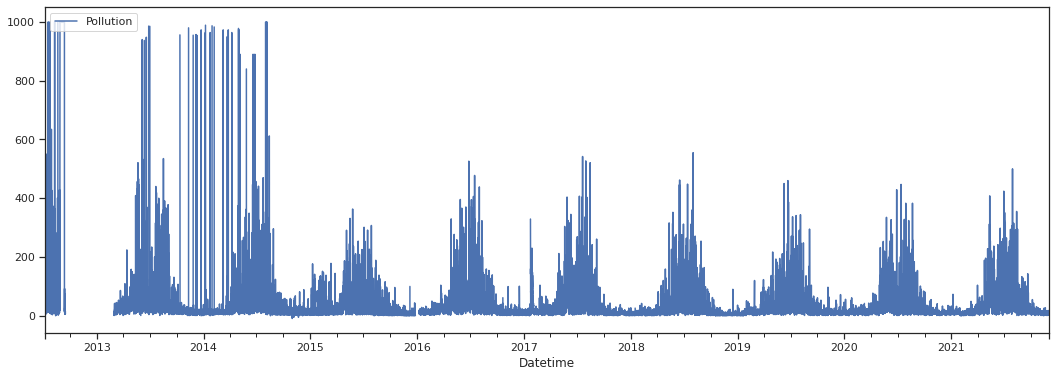

In [12]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df.plot(x="Datetime", y="Pollution", ax=ax)
plt.legend(loc='upper left')

plt.savefig('images/intro-visualization.png'); ## recuerda crear la carpeta 'images'


# Modelo Prophet con algunos detalles
En las siguientes líneas, se comenzará a usar el modelo Prophet, teniendo en cuenta algunas consideraciones adicionales, que se explicarán en cada apartado.

In [13]:
from fbprophet import Prophet

Se toman los días feriados desde el año 2012 hasta el año 2021. Esta consideración no es tan importante en este caso, pero se toma en cuenta para agregar precisión al modelo.

In [14]:
import holidays

years = range(2012, 2021)
all_holidays = holidays.CL(years=years)


In [15]:
df_holidays = pd.DataFrame.from_dict(all_holidays, orient="index").reset_index()
df_holidays.columns = ["ds", "holiday"]

Prophet posee un mecanismo para agregar sucesos importantes en las series de tiempo, que pudieron haber alterado los datos de alguna forma. En este caso, en la gráfica se puede ver que al inicio del año 2017, existen picos anormales en el material particulado, incluso sabiendo que en esas fechas nos encontramos en verano y no debería haber contaminación por estufas. Pero, entre los meses de enero y febrero del año 2017, en Chile hubo una seguidilla de incendios forestales en gran parte del país, siendo la zona centro-sur la más afectada. Dicho esto, es necesario que este acontecimiento sea agregado al modelo como un punto importante. Se agrega la fecha 1 de enero del año 2017, fecha en donde comenzaro los incendios.




In [16]:
from datetime import date

changepoints = {
    date(2017,1,1): "Massive forest fires in 2017 summer in Chile"
}

Acá se procede a entrenar el modelo Prophet con los siguientes parámetros:


*   **yearly_seasonality=True:** La calidad del aire sí cambia durante el año.
*   **weekly_seasonality=False:** En las épocas de peor calidad de aire, el cambio
de la calidad del aire entre días y semanas no es fuerte.
*   **daily_seasonality=True:** La calidad de aire sí cambia dependiendo la hora del día.
*   **holidays=df_holidays:** El modelo recibe los feriados de Chile obtenidos anteriormente.
*   **changepoints=list(changepoints.keys()):** El modelo recibe los puntos importantes en el tiempo.

El entrenamiento y las predicciones tardan un poco de tiempo debido a la cantidad de datos.










In [22]:
df.columns = ['ds', 'y']
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=True,
    holidays=df_holidays,
    changepoints=list(changepoints.keys())
    ).fit(df)

Las predicciones se hicieron siguiendo la técnica de Non-Daily Data especificada en la documentación de Prophet. Esta técnica permite trabajar con fechas y además horas. El siguiente link especifica más a detalle: [Non-Daily Data | Prophet](https://facebook.github.io/prophet/docs/non-daily_data.html). Los parámetros utilizados son los siguientes:


*   **periods=8760:** Configura una predicción 1 año después (un año tiene 8760 horas).
*   **freq='H':** Frecuencia expresada en horas.

El modelo muestra la gráfica azul (predicción) y la gráfica negra (dataset) juntas para compararlas. Además se crea una predicción para el año 2022 respecto al material particulado.



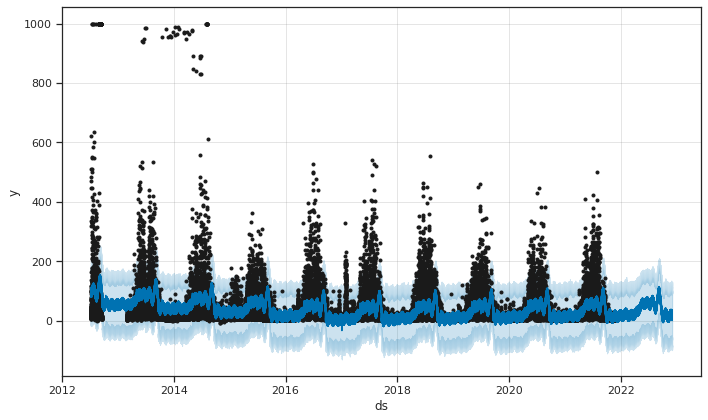

In [23]:

future = m.make_future_dataframe(periods=8760, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

Estos son algunos gráficos que muestran los datos de una manera más detallada. En los gráficos **yearly**, se puede ver que efectivamente el material particulado aumenta entre los meses de mayo y septiembre, pertenecientes a la estación de invierno. En los gráficos **daily**, se muestra que la calidad del aire empeora en ciertas horas del día.

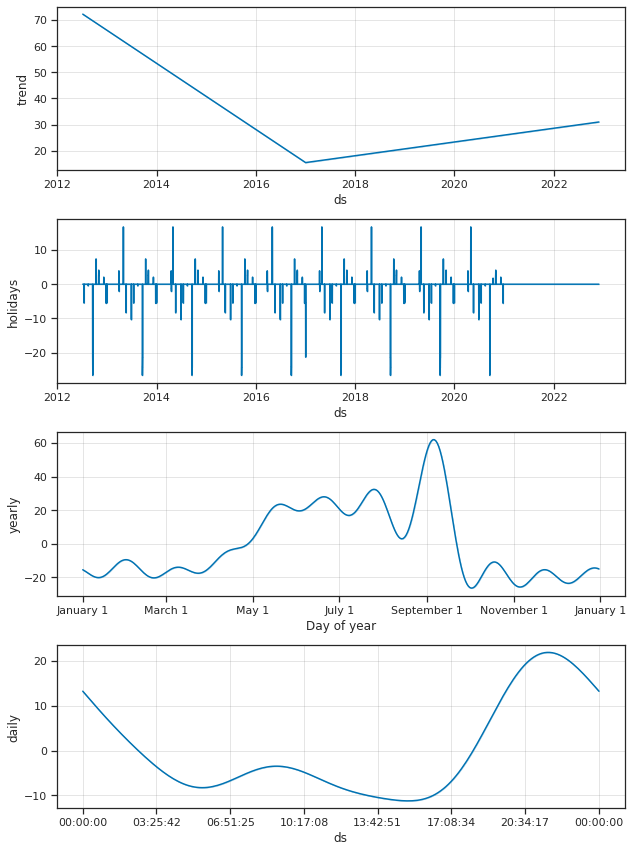

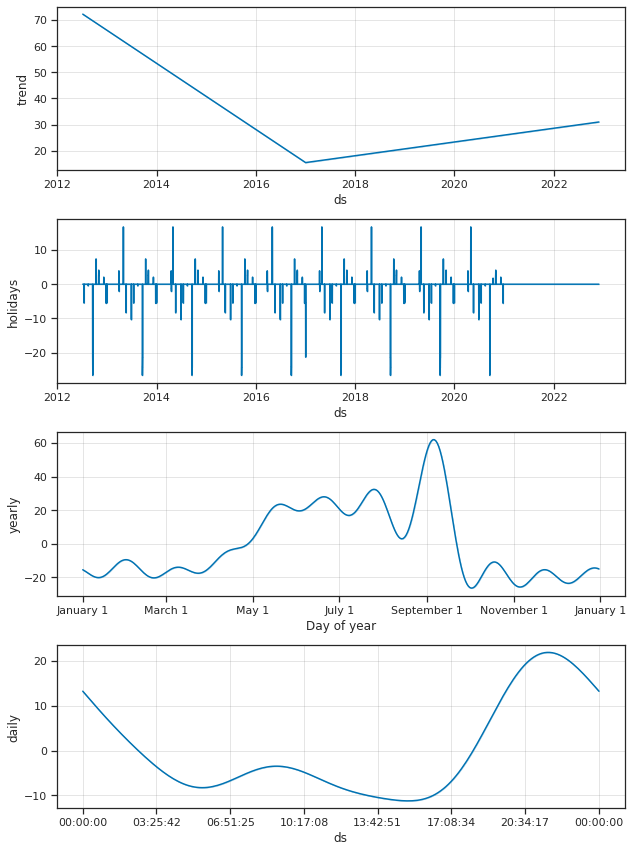

In [19]:
m.plot_components(fcst)

Prophet además posee mecanismos para revisar la performance del algoritmo, mostrando una tabla con distintos parámetros de desempeño. En la documentación de Prophet se explica con mayor detalle: [Diagnostics | Prophet](https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation)

In [24]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
cutoffs = pd.to_datetime(['2020-01-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days')


df_p = performance_metrics(df_cv)
df_p.head()

  0%|          | 0/1 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 14:00:00,183.959457,13.563165,10.595771,1.658591,0.840339,1.0
1,36 days 15:00:00,183.956731,13.563065,10.595500,1.660166,0.842203,1.0
2,36 days 16:00:00,183.830642,13.558416,10.588885,1.663327,0.842386,1.0
3,36 days 17:00:00,183.650220,13.551761,10.578344,1.663011,0.842386,1.0
4,36 days 18:00:00,183.665402,13.552321,10.578959,1.664273,0.842386,1.0
